In [25]:
# PyTorch
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn

# Data science tools
import numpy as np
import pandas as pd
import os

# Image manipulations
from PIL import Image

import matplotlib.pyplot as plt

In [152]:
import scipy
import zipfile
import sklearn
from sklearn import metrics
# Timing utility
from timeit import default_timer as timer

### References:
- https://github.com/mulholo/flower-classifier/blob/master/Flower_Classifier.ipynb
- https://github.com/Leo-xxx/pytorch-notebooks/blob/master/Torn-shirt-classifier/VGG16-transfer-learning.ipynb
- https://towardsdatascience.com/transfer-learning-with-vgg16-and-keras-50ea161580b4
- https://medium.com/@ledubmurukp/how-to-do-transfer-learning-from-the-keras-vgg16-model-17470c1cdded

## Image Preprocessing
1. Download the dataset
2. Do some exploratory analysis. Understand how many classes are there, how many data points do we have in each class
3. Find out the size of each of the datapoints, and carry out image resizing

In [3]:
current_directory = os.getcwd()
print(current_directory)

/Users/kaijun/Desktop/NTU/Year 4 Sem 1/SC4001 Neural Network & Deep Learning/Group Project/SC4001-Group-Project


In [4]:
# curl -L -o ./archive.zip \
# https://www.kaggle.com/api/v1/datasets/download/nunenuh/pytorch-challange-flower-dataset

In [5]:
# # https://stackoverflow.com/questions/3451111/unzipping-files-in-python
# with zipfile.ZipFile(current_directory + "/archive.zip", 'r') as zip_ref:
#     zip_ref.extractall(current_directory)

In [6]:
# dataset = datasets.Flowers102(root=current_directory, download=True)
# print(type(dataset))

In [7]:
# mat_dict = scipy.io.loadmat(current_directory + "/flowers-102/imagelabels.mat")
# label_df = pd.DataFrame(data=mat_dict["labels"][0], columns=["labels"])
# label_df

In [8]:
# # Group by the 'labels' column and count the occurrences of each label
# grouped_df = label_df.groupby(['labels'])['labels'].count().reset_index(name='count')
# grouped_df

In [9]:
# # get the id for train, validation, and test set
# mat_dict = scipy.io.loadmat(current_directory + "/flowers-102/setid.mat")
# mat_dict

In [10]:
# train_id = list(mat_dict["trnid"][0])
# test_id = list(mat_dict["tstid"][0])
# val_id = list(mat_dict["valid"][0])
# print("train_id:", train_id)
# print("test_id:", test_id)
# print("val_id:", val_id)

In [11]:
# the code below is used to find the sizes of each of the images
# for x in os.listdir(current_directory + "/flowers-102/jpg/"):
#     im = Image.open(current_directory + "/flowers-102/jpg/" + x)
#     w, h = im.size
#     print("w", w, "h", h)

## Training
1. Use the vgg16 for transfer learning
2. Freeze the convolutional weights + add additional layers to the end of the model to finetune to the classification task required
3. Look into Mix-Up if you have the time

### Get the base model and the weights

In [62]:
# get the model weights
weights = models.VGG16_Weights.IMAGENET1K_V1
weights

VGG16_Weights.IMAGENET1K_V1

In [129]:
vgg16 = models.vgg16(weights=weights)
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [104]:
# print("features", vgg16.features)
print("classifier", vgg16.classifier)


classifier Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [75]:
preprocess = weights.transforms()
preprocess

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

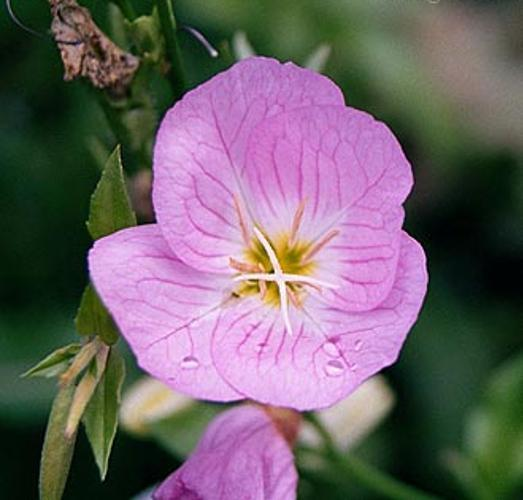

In [90]:
img = Image.open("./dataset/train/1/image_06734.jpg")
img

In [91]:
# Step 3: Apply inference preprocessing transforms
batch = preprocess(img).unsqueeze(0)
batch.shape

torch.Size([1, 3, 224, 224])

In [84]:
batch.squeeze(0).shape

torch.Size([1, 1, 3, 224, 224])

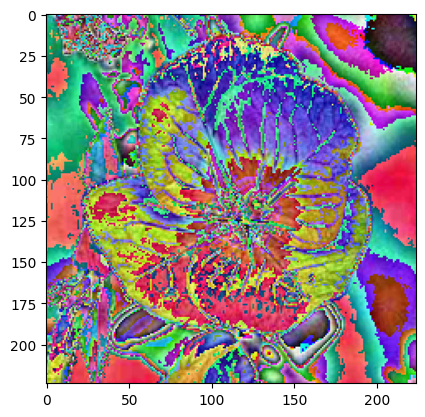

In [86]:
# transform the image and show the transformed image
transform = transforms.ToPILImage()
img = transform(batch.squeeze(0))
plt.imshow(img)

In [92]:
# Step 4: Use the model and print the predicted category
prediction = vgg16(batch).squeeze(0).softmax(0)
class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = weights.meta["categories"][class_id]
print(f"{category_name}: {100 * score:.1f}%")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
bee: 50.3%


In [111]:
n_inputs = vgg16.classifier[6].out_features
n_inputs

1000

## Hyperparameter tuning:
- Tune the image processing methods:
  - Only augment the training data. Decide between augmenting and not augmenting the image data
- Tune the number of neurones: [128, 256, 512]
- Tune the number of layers:
  - For now, we will stick to 3 layers
- Number of epochs:
  - For now, we will stick to 10

In [105]:
# class VGG16FineTune(nn.Module):
#     def __init__(self, no_features):
#         super(VGG16FineTune, self).__init__()
#         # VGG16's original feature extractor remains unchanged
#         self.features = vgg16.features

#         # Add an 
        
#         # Adjusted classification module
#         self.classifier = nn.Sequential(
#             nn.Linear(25088, no_features),  # VGG16's original structure
#             nn.ReLU(inplace=True),
#             nn.Dropout(p=0.5),
#             nn.Linear(no_features, no_features),
#             nn.ReLU(inplace=True),
#             nn.Dropout(p=0.5),
#             nn.Linear(no_features, 102),  # Change out_features to match 102 classes
#             nn.Softmax()
#         )

#     def forward(self, X):
#         X = self.features(X)
#         # flatten the feature maps into single vectors for fully connected layers
#         X = torch.flatten(X)
#         y = self.classifier(X)
#         return y


In [175]:
class VGG16FineTune(nn.Module):
    def __init__(self):
        super(VGG16FineTune, self).__init__()

        # get the base model
        # initiate new instance, so that they don't interfere with each other
        weights = models.VGG16_Weights.IMAGENET1K_V1
        base = models.vgg16(weights=weights)

        # freeze all of the previous layers
        for param in base.parameters():
            param.requires_grad = False

        # VGG16's original feature extractor remains unchanged
        self.features = base.features

        last_input_feature = base.classifier[6].in_features  # Input to the last layer
        self.classifier = nn.Sequential(
            *list(base.classifier[:-1]),  # Retain all layers except the last one
            nn.Linear(last_input_feature, 102)  # Output layer for 102 classes
        )

    def forward(self, X):
        print("before passing to model", X.shape)
        X = self.features(X)
        # flatten the feature maps into single vectors for fully connected layers
        print("before flattening:", X.shape)
        X = torch.flatten(X, 1)
        print("after flattening:", X.shape)
        y = self.classifier(X)
        return y

In [176]:
# early stopping obtained from tutorial
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [177]:
# ensure that the necessary layers in the model are frozen
def train(model, epochs, train_dataloader, val_dataloader, checkpoint_name):

    # initialise the optimizer and the criterion
    optimizer = optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()

    # create the early stopper object
    early_stopper = EarlyStopper()

    # check if gpu is available. If yes, use gpu
    train_on_gpu = cuda.is_available()
    print("train_on_gpu:", train_on_gpu)
    if train_on_gpu:
        model = model.to("cuda")

    # store the loss, and accuracy across each epoch
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []

    # train for the specific number of epochs
    for e in range(epochs):
        print(f"------ Start epoch: {e} ------")
        # find the average training loss and accuracy
        epoch_train_loss = []
        epoch_train_acc = []

        epoch_val_loss = []
        epoch_val_acc = []

        # train phase
        # set the mode of the model
        model.train()
        start = timer()
        for batch, (X, y_true) in enumerate(train_dataloader):

            # iterate over each batch using the train data loader

            if train_on_gpu:
                X, y_true = X.cuda(), y_true.cuda()

            print("X.shape", X.shape, "y_true.shape", y_true.shape)
            # Forward Pass
            y_pred = model(X)

            # calculate the loss
            loss = criterion(y_pred, y_true)
            loss.backward()
            epoch_train_loss.append(loss.detach().numpy())

            # Update the parameters
            optimizer.step()

            # calculate the accuracy
            batch_accuracy = metrics.accuracy_score(y_true=y_true, y_pred=y_pred)
            epoch_train_acc.append(batch_accuracy)

            # Track training progress
            print(
                f"Epoch: {e}\t{100 * (batch + 1) / len(train_dataloader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.",
                end="\r",
            )

        # validation phase
        with torch.no_grad():
            # set the model to eval phase
            model.eval()

            for X, y_true in val_dataloader:
                # iterate over each batch using the train data loader

                if train_on_gpu:
                    X, y_true = X.cuda(), y_true.cuda()

                # calculate the loss
                y_pred = model(X)
                loss = criterion(y_pred, y_true)
                epoch_val_loss.append(loss.detach().numpy())

                # calculate the accuracy
                batch_accuracy = metrics.accuracy_score(y_true=y_true, y_pred=y_pred)
                epoch_val_acc.append(batch_accuracy)

        train_loss.append(np.mean(epoch_train_loss))
        val_loss.append(np.mean(epoch_val_loss))

        train_acc.append(np.mean(epoch_train_acc))
        val_acc.append(np.mean(epoch_val_acc))

        # early stopping
        if early_stopper.early_stop(val_loss[-1]):
            break

    # save the model parameters to a file
    torch.save(model, checkpoint_name)

    return train_loss, train_acc, val_loss, val_acc

### Dataloaders

In [142]:
# get the model weights
weights = models.VGG16_Weights.IMAGENET1K_V1
preprocess = weights.transforms()
preprocess

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [143]:
# # Image transformations
# # Todo: check the transformations too
# image_transforms = {
#     # Train uses data augmentation
#     "train": transforms.Compose(
#         [
#             transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
#             transforms.RandomRotation(degrees=30),
#             transforms.ColorJitter(),
#             transforms.RandomHorizontalFlip(),
#             transforms.ToTensor(),
#             transforms.Normalize(
#                 [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
#             ),  # Imagenet standards
#         ]
#     ),
#     # Validation does not use augmentation
#     "val": transforms.Compose(
#         [
#             transforms.Resize(size=224),
#             transforms.ToTensor(),
#             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
#         ]
#     ),
#     # Test does not use augmentation
#     "test": transforms.Compose(
#         [
#             transforms.Resize(size=224),
#             transforms.ToTensor(),
#             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
#         ]
#     ),
# }

In [144]:
train_dir = current_directory + "/dataset/train"
test_dir = current_directory + "/dataset/test"
valid_dir = current_directory + "/dataset/valid"

batch_size = 64

In [145]:
data = {
    'train':
    datasets.ImageFolder(root=train_dir, transform=preprocess),
    'val':
    datasets.ImageFolder(root=valid_dir, transform=preprocess),
    # 'test':
    # datasets.ImageFolder(root=test_dir, transform=image_transforms['test'])
}

# Dataloader iterators
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True),
    # 'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)
}


In [147]:
model = VGG16FineTune()

In [150]:
train_dataloader = dataloaders["train"]
val_dataloader = dataloaders["val"]
checkpoint_name = "add-last-layer-epoch-5"
epochs = 5

In [ ]:
train_loss, train_acc, val_loss, val_acc = train(model, epochs, train_dataloader, val_dataloader, checkpoint_name)

train_on_gpu: False
------ Start epoch: 0 ------
X.shape torch.Size([64, 3, 224, 224]) y_true.shape torch.Size([64])


## Results
- Calculate accuracy. Plot the error over time
- Check for accuracy even after image augmentation

In [162]:
vgg16 = models.vgg16()
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [172]:
VGG16FineTune().classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=102, bias=True)
)